In [4]:
!gdown --id '1t5UFJ4qtRFwdveSN-6Dfb8UYdaqk5Pl7' --output train_50.zip
!gdown --id '1A4BzGflF3iMEdLR3ZdIYombuawWCS8bY' --output val_50.zip


# !gdown --id '18YPZJCOlNnlHgpqsyQ2qGqsWgyRz1ifD' --output train_50.zip
# !gdown --id '18OkDQJbOrgog2iHOMQR_OtFijq81YZYM' --output val_50.zip

# !wget -O train_50.zip https://drive.google.com/file/d/1UOdOXzZiCH5513vKAg35LYCz6ldAtzng/view?usp=sharing
# !wget -O val_50.zip https://drive.google.com/file/d/1RzAXr-yKfvTzzvs6kX0N7s6nTmMpGdjH/view?usp=sharing

!unzip train_50.zip
!unzip val_50.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_50/44/44_61.png   
  inflating: train_50/44/44_231.png  
  inflating: train_50/44/44_88.png   
  inflating: train_50/44/44_148.png  
  inflating: train_50/44/44_369.png  
  inflating: train_50/44/44_166.png  
  inflating: train_50/44/44_152.png  
  inflating: train_50/44/44_448.png  
  inflating: train_50/44/44_121.png  
  inflating: train_50/44/44_439.png  
  inflating: train_50/44/44_400.png  
  inflating: train_50/44/44_227.png  
  inflating: train_50/44/44_387.png  
  inflating: train_50/44/44_22.png   
  inflating: train_50/44/44_169.png  
  inflating: train_50/44/44_193.png  
  inflating: train_50/44/44_160.png  
  inflating: train_50/44/44_353.png  
  inflating: train_50/44/44_125.png  
  inflating: train_50/44/44_309.png  
  inflating: train_50/44/44_276.png  
  inflating: train_50/44/44_14.png   
  inflating: train_50/44/44_180.png  
  inflating: train_50/44/44_420.png  
  inflating: train_50/44/44_250.png  

# Loading Pytorch module

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os 
import numpy as np
from PIL import Image

# Creat Custom Dataset

In [6]:
class Part1(Dataset):
  def __init__(self, root, transform=None):
    self.images = None
    self.labels = None
    self.filenames = []
    self.root = root

    for i in range(50):
      filenames = glob.glob(os.path.join(root, str(i), '*.png'))
      for fn in filenames:
        self.filenames.append((fn, i))

    self.len = len(self.filenames)
    self.transform = transform


  def __getitem__(self, index):

    image_fn, label = self.filenames[index]
    image = Image.open(image_fn)

    if self.transform is not None:
      image = self.transform(image)

    return image, label


  def __len__(self):

    return self.len

# Data Augmentation

In [7]:
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15),
  transforms.ToTensor(),
])

size = (28, 28)
padding = 2
fill = (0, 0, 255)

train_transform2 = transforms.Compose([
  
  transforms.CenterCrop(size),
  transforms.Pad(padding, fill),
  transforms.ToTensor(),
])

# Load the image into custom-created Dataset

In [8]:

# trainset = Part1(root = 'train_50/', transform = transforms.ToTensor())
trainset = Part1(root = 'train_50/', transform = transforms.ToTensor())
trainset2 = Part1(root = 'train_50/', transform = train_transform)
trainset3 = Part1(root = 'train_50/', transform = train_transform2)


trainset = trainset + trainset2 + trainset3


testset = Part1(root = 'val_50/', transform = transforms.ToTensor())



print('# of images in trainset: ', len(trainset))
print('# of images in testset: ', len(testset))

# of images in trainset:  67500
# of images in testset:  2500


# Collect data into batches

In [10]:
trainset_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1)
testset_loader = DataLoader(testset, batch_size=500, shuffle=False, num_workers=1)


dataiter = iter(trainset_loader)
images, labels = dataiter.next()

print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

Image tensor in each batch: torch.Size([256, 3, 32, 32]) torch.float32
Label tensor in each batch: torch.Size([256]) torch.int64


# Visualize what contains in each batch

Labels:
tensor(12) tensor(44) tensor(20) tensor(47) tensor(36) tensor(30) tensor(9) tensor(8)


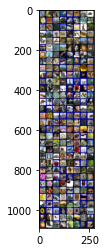

In [11]:
import matplotlib.pyplot as plt


def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(8)))

# Check if GPU is available. If not, use CPU instead.

In [12]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

Device used: cuda


# Creating a VGG16 model

In [13]:

import torchvision.models as models
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model_ft = models.vgg16_bn(pretrained=True)
model_ft.classifier[6] = nn.Linear(4096,50)
# model.eval()
model = model_ft.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train the network

In [14]:
from torch.optim.lr_scheduler import StepLR
def train(model, epoch, log_interval=100):
  # optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay = 0.0001)
  optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.8, weight_decay=0.0001)
  criterion = nn.CrossEntropyLoss()
  model.train()

  scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

  iteration = 0
  for ep in range(epoch):
    scheduler.step()
    print('Epoch:', ep,'LR:', scheduler.get_lr())
    for batch_idx, (data, target) in enumerate(trainset_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      if iteration % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          ep, batch_idx * len(data), len(trainset_loader.dataset),
          100. * batch_idx / len(trainset_loader), loss.item()))
      iteration += 1

    test(model)

# Evaluate at the end of each epoch

In [21]:
# prediction = []
filename = []

def test(model):
  criterion = nn.CrossEntropyLoss()
  model.eval()
  test_loss = 0
  correct = 0
  prediction = []

  with torch.no_grad():
    for data, target in testset_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.max(1, keepdim=True)[1]

      correct += pred.eq(target.view_as(pred)).sum().item()

      for y in (pred):
        prediction.append(y)

  print(len(prediction))

  test_loss /= len(testset_loader)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testset_loader.dataset),
    100. * correct / len(testset_loader.dataset)))
  
  if (100. * correct / len(testset_loader.dataset) > 72):

    for i in range(50):
      filenames = glob.glob(os.path.join('val_50/', str(i), '*.png'))
      for fn in filenames:
        filename.append(fn)

    print(len(filenames))

    d = {'prediction':prediction, 'file_name':filename}
    import pandas as pd
    df = pd.DataFrame(d)
    df = df.sort_values(by=['file_name'])
    output_path = '/content/' + 'test_pred.csv'
    with open(output_path, 'w') as f:
      f.write('image_id,label\n')
      for index, row in df.iterrows():
        f.write('{},{}\n'.format(row['file_name'],row['prediction']))


# Time to train the model

In [22]:
train(model, 100)

Epoch: 0 LR: [0.009600000000000001]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train Epoch: 0 [0/67500 (0%)]	Loss: 0.092678
Train Epoch: 0 [25600/67500 (38%)]	Loss: 0.113939
Train Epoch: 0 [51200/67500 (76%)]	Loss: 0.147726
2500

Test set: Average loss: 1.2093, Accuracy: 1870/2500 (75%)

50
Epoch: 1 LR: [0.007680000000000001]
Train Epoch: 1 [9216/67500 (14%)]	Loss: 0.299894
Train Epoch: 1 [34816/67500 (52%)]	Loss: 0.205922
Train Epoch: 1 [60416/67500 (89%)]	Loss: 0.212416


KeyboardInterrupt: ignored

In [1]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [58]:
prediction = []

with torch.no_grad():
  for i, data in enumerate(testset_loader):
    

    val_pred = model(data.cuda())
    pred_label = np.argmax(val_pred.cpu().data.numpy(), axis = 1)
    for y in (pred_label):
      prediction.append(y)
d = {'prediction':prediction, 'file_name':image_dir}

import pandas as pd
df = pd.DataFrame(d)
df = df.sort_values(by=['file_name'])
output_path = output_folder + 'test_pred.csv'
with open(output_path, 'w') as f:
  f.write('image_id,label\n')
  for index, row in df.iterrows():
    f.write('{},{}\n'.format(row['file_name'],row['prediction']))

AttributeError: ignored